In [55]:
from itertools import chain
from collections import defaultdict, Counter
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor


from utils import split_data_regression, add_coordinates

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import warnings
warnings.filterwarnings("ignore")

from utils import draw_regression_accuracy

draw_accuracy = lambda model, params: draw_regression_accuracy(df, 40, 300, 400, 8, model, params)

In [56]:
np.random.seed(42)

# Lateration

In [57]:
df = pd.read_csv('../data/fingerprinting_2.csv', index_col='Unnamed: 0')
df = df.reset_index(drop=True)

In [58]:
grouped = df.groupby("Square")

point1 = grouped.get_group("s1").iloc[-100:]
point1["Point"] = 39
point1["Orientation"] = 3.0

point2 = grouped.get_group("s2").iloc[-100:]
point2["Point"] = 39
point2["Orientation"] = 3.0

df = df.append([point1, point2]).reset_index(drop=True)

In [59]:
df = add_coordinates(df)
beacons = ["Server-RSSI-" + str(i) for i in range(1, 6)]
beacons_dist = list(map(lambda x: x+"-distance", beacons))
beacons_location = np.array(
    [
        [0, 400+20], 
        [0,400-420],
        [350,400-430],
        [350, 400-200],
        [350, 400-25], 
    ])
# beacons_location = np.array([[0, -20], [350, 25], [350, 200],[350, 430],[0, 420]])

for b_name, b_loc in zip(beacons, beacons_location):
    df[b_name+"-distance"] = ((df["x"] - b_loc[0])**2 + (df["y"] - b_loc[1])**2)**0.5
df

,Server-RSSI-1,Server-RSSI-2,Server-RSSI-3,Server-RSSI-4,Server-RSSI-5,Square,Point,Orientation,x,y,Server-RSSI-1-distance,Server-RSSI-2-distance,Server-RSSI-3-distance,Server-RSSI-4-distance,Server-RSSI-5-distance
0,-55,-71,-69,-57,-58,s0,0,0.0,20,380,44.721360,400.499688,526.307895,375.898923,330.037877
1,-57,-64,-58,-48,-58,s0,0,0.0,20,380,44.721360,400.499688,526.307895,375.898923,330.037877
2,-57,-64,-58,-48,-58,s0,0,0.0,20,380,44.721360,400.499688,526.307895,375.898923,330.037877
3,-57,-64,-57,-48,-58,s0,0,0.0,20,380,44.721360,400.499688,526.307895,375.898923,330.037877
4,-57,-65,-57,-48,-58,s0,0,0.0,20,380,44.721360,400.499688,526.307895,375.898923,330.037877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,-64,-64,-74,-53,-35,s2,39,3.0,254,350,263.469163,448.793939,391.938771,178.089865,99.201814
47996,-63,-65,-72,-53,-35,s2,39,3.0,254,350,263.469163,448.793939,391.938771,178.089865,99.201814
47997,-63,-65,-72,-54,-35,s2,39,3.0,254,350,263.469163,448.793939,391.938771,178.089865,99.201814
47998,-63,-65,-72,-53,-35,s2,39,3.0,254,350,263.469163,448.793939,391.938771,178.089865,99.201814


In [60]:
import itertools
from utils import get_samples_by_points_num

def split_data_lateration(df, points_num, train_part, validation_part, test_part):
    assert train_part + validation_part + test_part == 1
    division = (np.array(
        points_num*np.array([train_part, validation_part, test_part]))).astype(int)
    assert np.sum(division) == points_num
    for i in range(1, len(division)):
        division[i] += division[i-1]
    division = division[:-1]

    return itertools.chain.from_iterable(
        map(lambda data: (data[beacons], data[map(lambda x: x+"-distance", beacons)]),
            map(lambda points: get_samples_by_points_num(df, points),
                np.split(np.random.permutation(np.arange(points_num)), division))))


In [61]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data_lateration(
    df, points_num=40, train_part=0.7, validation_part=0.15, test_part=0.15)

# One regressor to rule them all

## Visualize data

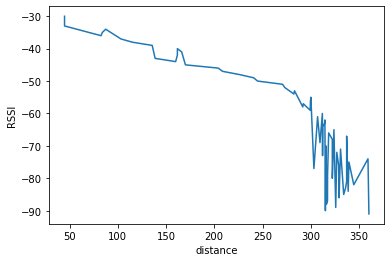

In [62]:
df_merged = pd.DataFrame({"RSSI": pd.concat( [df[b] for b in beacons]), 
                          "distance": pd.concat([df[b] for b in beacons_dist])})
mn = df_merged.groupby("RSSI").mean()
sns.lineplot(x=mn["distance"], y=mn.index)

## Maybe models can handle this ?)

Mean absolute error for RandomForest: 77.24048734361438
Mean absolute error for XGB: 77.24362556234092
Mean absolute error for Linear Regression: 79.04089083977546


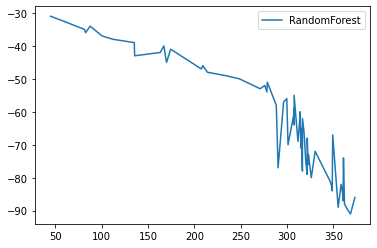

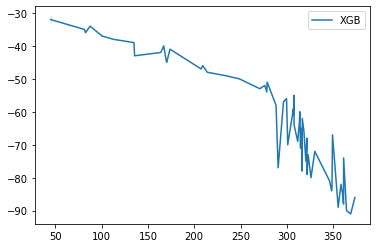

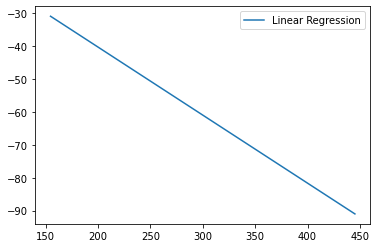

In [63]:
for model, name in zip([RandomForestRegressor(), XGBRegressor(), LinearRegression()], ["RandomForest", "XGB", "Linear Regression"]):
    X_train_all = pd.concat([X_train[b] for b in beacons]).values.reshape(-1,1)
    y_train_all = pd.concat([y_train[b] for b in map(lambda x: x+"-distance", beacons)]).values
    model.fit(X_train_all, y_train_all)
    predicted = model.predict(pd.concat([X_val[b] for b in beacons]).values.reshape(-1,1))
    err = mean_absolute_error(pd.concat([y_val[b] for b in map(lambda x: x+"-distance", beacons)]), predicted)
    print(f"Mean absolute error for {name}: {err}")

    rssi = np.arange(X_train_all.min(), X_train_all.max(), 1)
    dist = model.predict(rssi.reshape(-1, 1))

    fig = plt.figure()
    line = sns.lineplot(x=dist, y=rssi)
    legend = plt.legend([name])

# One regressor per each beacon

## Visualize data

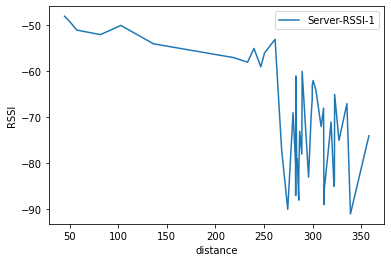

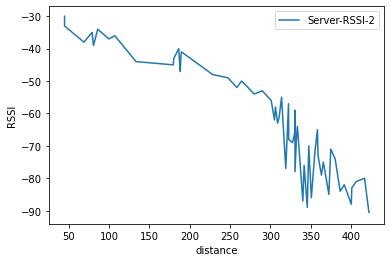

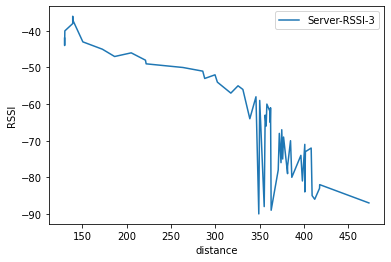

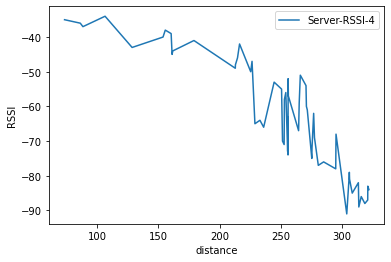

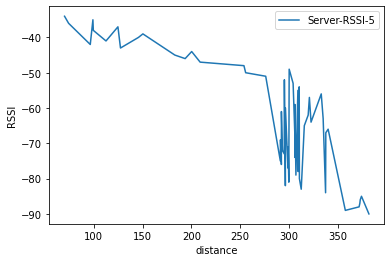

In [80]:
for name, dist in zip(beacons, beacons_dist):
    df_per_beacon = pd.DataFrame({"RSSI": df[name], 
                                  "distance": df[dist]})
    mn = df_per_beacon.groupby("RSSI").mean()
    fig = plt.figure()
    line = sns.lineplot(x=mn["distance"], y=mn.index)
    legend = plt.legend([name])

## Maybe models will handle this ? (Part two)

In [81]:
def get_per_beacon_models(model, params):
    models = []
    for b_name, param in zip(beacons, params):
        models.append(model(**param))
        models[-1].fit(X_train[[b_name]].values, y_train[b_name+"-distance"].values)
    return models
        
def evaluate_models(models):
    accs = []
    for i, beacon in enumerate(beacons):
        predicted = models[i].predict(X_val[[beacon]].values)
        acc = mean_absolute_error(y_val[beacon+"-distance"], predicted)
        print("Mean absolute error for {} beacon: {:2}".format(i+1, acc))
        accs.append(acc)
    print("Mean absolute error: {:2}".format(np.mean(np.array(accs))))

In [82]:
# minimizing distance
def model_accuracy(params,model,train_data,train_labels,cv_data,cv_labels):
    model = model(**params)
    model.fit(train_data, train_labels)
    preds = model.predict(cv_data)
    return {'loss': mean_absolute_error(cv_labels, preds), 'status': STATUS_OK}

## XGBRegressor

In [83]:
%%script false --no-raise-error
models_best_params_xgb = []
for i in beacons:
    max_depth = np.arange(3, 20, dtype=int)
    sampling_method = ['gradient_based', 'uniform']
    xgb_fspace = {
        'eta':hp.uniform('eta', 0.01, 1),
        'gamma':hp.uniform('gamma', 0.01, 1),
        'max_depth':hp.choice('max_depth', max_depth),
        'min_child_weight': hp.uniform('min_child_weight', 0, 1),
        'subsample': hp.uniform('subsample', 0, 1), 
        'sampling_method': hp.choice('sampling_method',sampling_method)
    }

    xgb_accuracy = lambda x:model_accuracy(x,model=XGBRegressor,train_data=X_train[[i]],train_labels=y_train[i+"-distance"],cv_data=X_val[[i]],cv_labels=y_val[[i+"-distance"]])
    trials = Trials()
    best_xgb = fmin(
        fn=xgb_accuracy,
        space=xgb_fspace,
        algo=tpe.suggest,
        max_evals=50, trials=trials, rstate=np.random.RandomState(0))
    best_xgb['sampling_method']=sampling_method[best_xgb['sampling_method']]
    best_xgb['max_depth']=max_depth[best_xgb['max_depth']]
    print('Best parameters: ')
    for param in best_xgb:
        print(param, best_xgb[param])
    models_best_params_xgb.append(best_xgb)

100%|██████████| 50/50 [00:27<00:00,  1.85trial/s, best loss: 93.13014730455001]
Best parameters: 
eta 0.4990722208936885
gamma 0.7754177373732427
max_depth 14
min_child_weight 0.613334425428097
sampling_method uniform
subsample 0.02256880270358344
100%|██████████| 50/50 [00:26<00:00,  1.87trial/s, best loss: 80.59650381411112]
Best parameters: 
eta 0.7188212245340684
gamma 0.7115346872920516
max_depth 11
min_child_weight 0.8619980301165149
sampling_method gradient_based
subsample 0.02241063973189128
100%|██████████| 50/50 [00:26<00:00,  1.86trial/s, best loss: 77.04306789161794]
Best parameters: 
eta 0.995305737149512
gamma 0.8659127197064723
max_depth 9
min_child_weight 0.8160289898763478
sampling_method gradient_based
subsample 0.06659140087046334
100%|██████████| 50/50 [00:27<00:00,  1.82trial/s, best loss: 61.170600648696016]
Best parameters: 
eta 0.11527594761695514
gamma 0.7249168412963541
max_depth 4
min_child_weight 0.8574846485149644
sampling_method uniform
subsample 0.616830

In [85]:
models_best_params_xgb = 
[{'eta': 0.4990722208936885,
  'gamma': 0.7754177373732427,
  'max_depth': 14,
  'min_child_weight': 0.613334425428097,
  'sampling_method': 'uniform',
  'subsample': 0.02256880270358344},
 {'eta': 0.7188212245340684,
  'gamma': 0.7115346872920516,
  'max_depth': 11,
  'min_child_weight': 0.8619980301165149,
  'sampling_method': 'gradient_based',
  'subsample': 0.02241063973189128},
 {'eta': 0.995305737149512,
  'gamma': 0.8659127197064723,
  'max_depth': 9,
  'min_child_weight': 0.8160289898763478,
  'sampling_method': 'gradient_based',
  'subsample': 0.06659140087046334},
 {'eta': 0.11527594761695514,
  'gamma': 0.7249168412963541,
  'max_depth': 4,
  'min_child_weight': 0.8574846485149644,
  'sampling_method': 'uniform',
  'subsample': 0.616830281088266},
 {'eta': 0.16309994675899536,
  'gamma': 0.9952796405334583,
  'max_depth': 3,
  'min_child_weight': 0.35390483477863127,
  'sampling_method': 'uniform',
  'subsample': 0.2293950898824746}]

[{'eta': 0.4990722208936885,
  'gamma': 0.7754177373732427,
  'max_depth': 14,
  'min_child_weight': 0.613334425428097,
  'sampling_method': 'uniform',
  'subsample': 0.02256880270358344},
 {'eta': 0.7188212245340684,
  'gamma': 0.7115346872920516,
  'max_depth': 11,
  'min_child_weight': 0.8619980301165149,
  'sampling_method': 'gradient_based',
  'subsample': 0.02241063973189128},
 {'eta': 0.995305737149512,
  'gamma': 0.8659127197064723,
  'max_depth': 9,
  'min_child_weight': 0.8160289898763478,
  'sampling_method': 'gradient_based',
  'subsample': 0.06659140087046334},
 {'eta': 0.11527594761695514,
  'gamma': 0.7249168412963541,
  'max_depth': 4,
  'min_child_weight': 0.8574846485149644,
  'sampling_method': 'uniform',
  'subsample': 0.616830281088266},
 {'eta': 0.16309994675899536,
  'gamma': 0.9952796405334583,
  'max_depth': 3,
  'min_child_weight': 0.35390483477863127,
  'sampling_method': 'uniform',
  'subsample': 0.2293950898824746}]

In [86]:
models_xgb = get_per_beacon_models(XGBRegressor, models_best_params_xgb)
evaluate_models(models_xgb)

Mean absolute error for 1 beacon: 93.13014730455001
Mean absolute error for 2 beacon: 80.59650381411112
Mean absolute error for 3 beacon: 77.04306789161794
Mean absolute error for 4 beacon: 61.170600648696016
Mean absolute error for 5 beacon: 71.40520505545577
Mean absolute error: 76.66910494288616


## RandomForestRegressor

In [87]:
%%script false --no-raise-error
models_best_params_rf = []
for i in beacons:
    max_depth = np.arange(3, 20, dtype=int)
#     max_features=np.arange(1,2,dtype=int)
    n_estimators=np.arange(100,201,50)
    rf_fspace = {
        'max_depth':hp.choice('max_depth', max_depth),
#         'max_features': hp.choice('max_features', max_features),
        'n_estimators': hp.choice('n_estimators',n_estimators )
    }

    rf_accuracy = lambda x:model_accuracy(x,model=RandomForestRegressor,train_data=X_train[[i]],train_labels=y_train[i+"-distance"],cv_data=X_val[[i]],cv_labels=y_val[[i+"-distance"]])
    trials = Trials()
    best_rf = fmin(
        fn=rf_accuracy,
        space=rf_fspace,
        algo=tpe.suggest,
        max_evals=50, trials=trials, rstate=np.random.RandomState(0))
#     best_rf['max_features']=max_features[best_rf['max_features']]
    best_rf['n_estimators']=n_estimators[best_rf['n_estimators']]
    best_rf['max_depth']=max_depth[best_rf['max_depth']]
    print('Best parameters: ')
    for param in best_rf:
        print(param, best_rf[param])
    models_best_params_rf.append(best_rf)

100%|██████████| 50/50 [00:35<00:00,  1.43trial/s, best loss: 87.13727590273064]
Best parameters: 
max_depth 3
n_estimators 150
100%|██████████| 50/50 [00:33<00:00,  1.51trial/s, best loss: 80.87958843251616]
Best parameters: 
max_depth 8
n_estimators 100
100%|██████████| 50/50 [00:28<00:00,  1.75trial/s, best loss: 77.4217570436759] 
Best parameters: 
max_depth 16
n_estimators 100
100%|██████████| 50/50 [00:40<00:00,  1.23trial/s, best loss: 59.841776617321564]
Best parameters: 
max_depth 4
n_estimators 200
100%|██████████| 50/50 [00:37<00:00,  1.32trial/s, best loss: 71.48773778570717]
Best parameters: 
max_depth 5
n_estimators 200


In [91]:
models_best_params_rf = [
 {'max_depth': 3, 'n_estimators': 150},
 {'max_depth': 8, 'n_estimators': 100},
 {'max_depth': 16, 'n_estimators': 100},
 {'max_depth': 4, 'n_estimators': 200},
 {'max_depth': 5, 'n_estimators': 200}]

In [92]:
models_rf = get_per_beacon_models(RandomForestRegressor, models_best_params_rf)
evaluate_models(models_rf)

Mean absolute error for 1 beacon: 87.2270098192671
Mean absolute error for 2 beacon: 80.88158291300734
Mean absolute error for 3 beacon: 77.45351421280947
Mean absolute error for 4 beacon: 59.91390711781729
Mean absolute error for 5 beacon: 71.49033434599566
Mean absolute error: 75.39326968177937


In [93]:
models_lin = get_per_beacon_models(LinearRegression, [{}]*5)
evaluate_models(models_lin)

Mean absolute error for 1 beacon: 89.7583819910306
Mean absolute error for 2 beacon: 76.3503980227782
Mean absolute error for 3 beacon: 77.74315187517345
Mean absolute error for 4 beacon: 59.26870197057377
Mean absolute error for 5 beacon: 74.11787020319917
Mean absolute error: 75.44770081255105


In [ ]:
models_svr = get_per_beacon_models(SVR, [{"kernel": "poly", "degree": 3}]*5)
evaluate_models(models_svr)

In [94]:
df[beacons].describe()

,Server-RSSI-1,Server-RSSI-2,Server-RSSI-3,Server-RSSI-4,Server-RSSI-5
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,-64.412937,-55.805479,-57.938042,-52.637292,-54.646813
std,6.644848,8.006210,7.469752,7.724370,7.069871
min,-91.000000,-91.000000,-90.000000,-91.000000,-90.000000
25%,-68.000000,-60.000000,-63.000000,-57.000000,-59.000000
50%,-64.000000,-56.000000,-57.000000,-51.000000,-54.000000
75%,-60.000000,-51.000000,-53.000000,-48.000000,-50.000000
max,-48.000000,-30.000000,-36.000000,-34.000000,-34.000000


In [95]:
df[beacons_dist].describe()

,Server-RSSI-1-distance,Server-RSSI-2-distance,Server-RSSI-3-distance,Server-RSSI-4-distance,Server-RSSI-5-distance
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,283.721301,283.721301,320.460152,232.292475,285.227999
std,103.782053,103.782053,101.458230,78.285378,96.739083
min,44.721360,44.721360,86.023253,72.801099,70.178344
25%,206.094612,206.094612,247.436721,177.129854,217.111922
50%,287.574185,287.574185,326.648368,232.053002,299.219525
75%,370.579270,370.579270,395.108669,300.311435,356.755704
max,488.262225,488.262225,526.307895,375.898923,484.690623


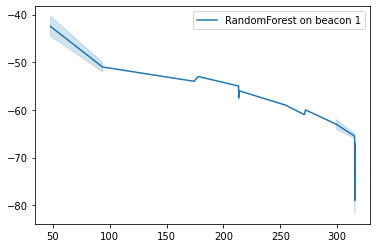

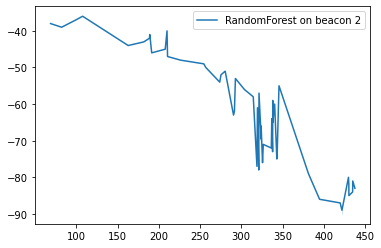

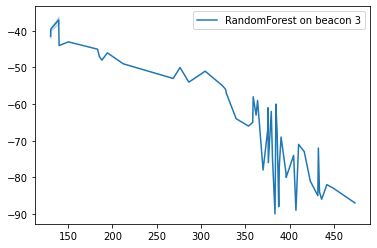

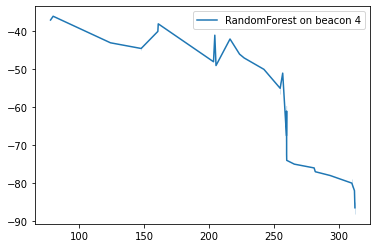

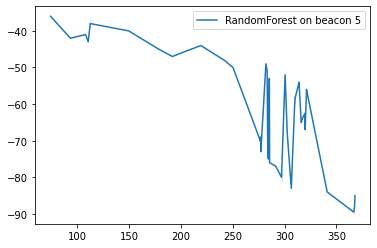

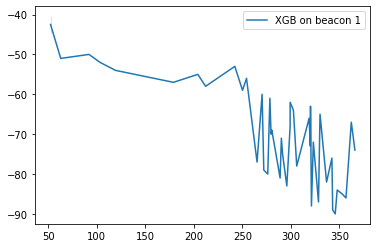

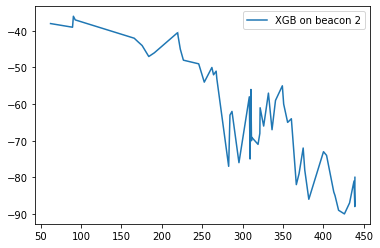

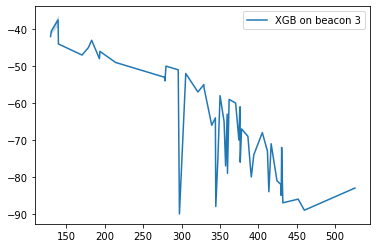

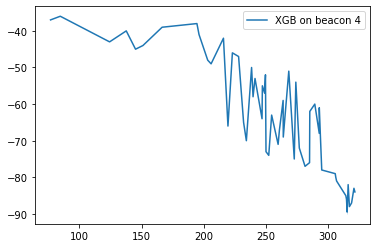

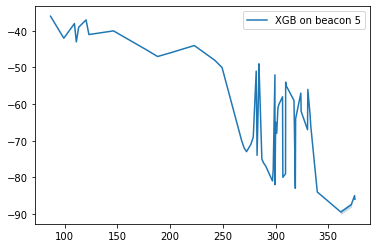

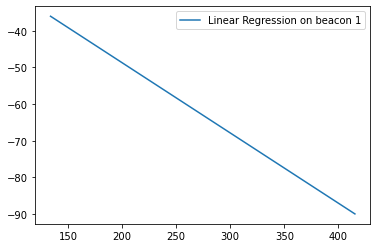

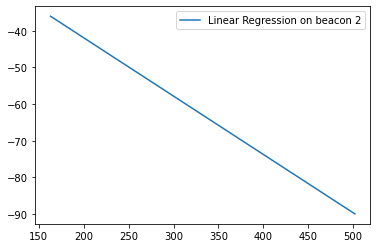

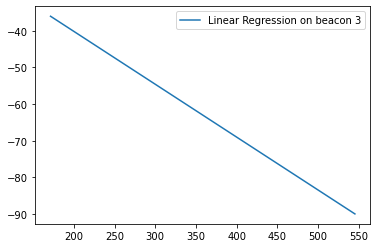

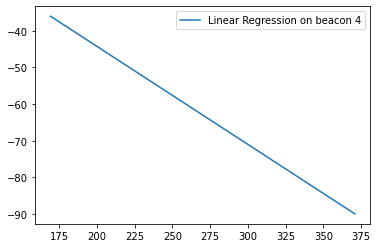

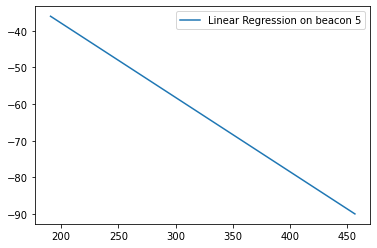

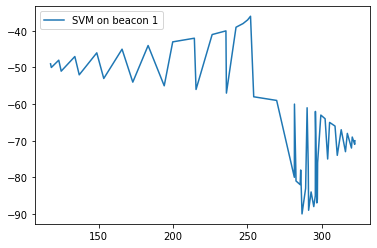

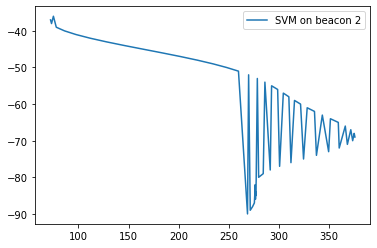

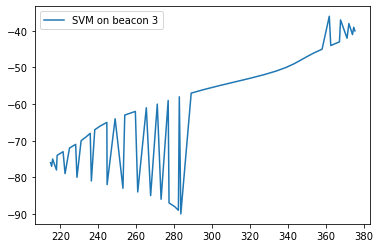

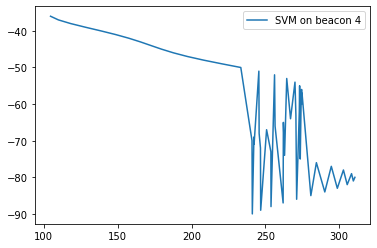

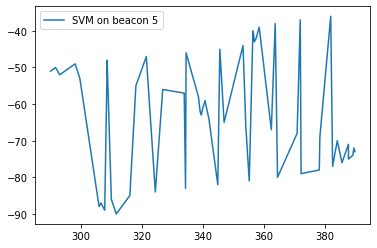

In [96]:
for models, name in zip([models_rf, models_xgb, models_lin, models_svr], ["RandomForest", "XGB", "Linear Regression", "SVM"]):
    rssi = np.arange(-90, -35, 1)
    dists = []
    for model in models:
        dists.append(model.predict(rssi.reshape(-1, 1)))

    for b_num, dist in enumerate(dists):
        fig = plt.figure()
        line = sns.lineplot(x=dist, y=rssi)
        legend = plt.legend([name + " on beacon " + str(b_num + 1)])